## 准备工作

In [4]:
import scipy.io as sio  # 从.mat文件中读取数据集
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # SVC用于分类，SVR用于回归
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from differential_evolution.differential_evolution import DifferentialEvolution
from utils.dataset_utils import get_classes_indexes_counts

(4,)
(4,)


### 实值映射到0-1

In [2]:
# 根据种群个体的编码值，获得要选择的实例的索引
def get_indices(x):
    x = np.round(x)  # 数据范围在0-2之间，转化成int的同时会舍去小数部分，从而将个体映射到0-1编码
    indices = np.where(x == 1)  # 1代表选择该实例，返回值是tuple，tuple[0]取元组中的第一个元素
    return indices[0]

### 获取实例子集

In [3]:
# 根据索引得到要选择的子集：数据和标签
# minimum的最大值不能超过数据集中包含的所有类别的最小数量
def get_sub_dataset(xi, indices, x, y, classes, minimum):
    # 根据索引得到实例子集
    num_class=len(classes)
    x_sub = x[indices, :]
    y_sub = y[indices]

    #print("实例子集x：", x_sub)
    #print("实例子集y：", y_sub)
    # 计算实例子集各个类别的数量
    counts_sub = np.zeros(num_class, dtype=int)
    for i in range(y_sub.shape[0]):
        counts_sub[y_sub[i]] += 1
    #print("实例子集的数量：", counts_sub)
    # 遍历子集中各个类别的数量，保证大于最小数量
    for i in range(num_class):
        # 当实例个数小于minimum，随机添加实例达到最小限制
        if counts_sub[i] < minimum:
            # 转换成集合进行差运算（& | -，分别是交、并、差） unselected_indices是一个set集合
            unselected_indices_set = set(classes[i]) - set(indices)
            # list(unselected_indices)将集合转换成list
            unselected_indices = np.array(list(unselected_indices_set))
            # replace=False表示不允许重复
            random_selecte_indices = np.random.choice(unselected_indices, size=minimum - counts_sub[i], replace=False)
            # 添加后更改个体xi的参数
            for j in range(0, minimum - counts_sub[i]):  # 小于minimum，添加实例时，需要同步更改xi个体的实值大小，由小于0.5，改为大于0.5
                xi[random_selecte_indices[j]] = np.random.uniform(0.5, 1)  # 生成0.5-1的随机数
                index = np.searchsorted(indices, random_selecte_indices[j])
                indices = np.insert(indices, index, random_selecte_indices[j])
                x_sub = np.insert(x_sub, index, x[random_selecte_indices[j], :], axis=0)
                y_sub = np.insert(y_sub, index, y[random_selecte_indices[j]])

            #print(f"类别{i}所要补充的个体数为{minimum - counts_sub[i]},索引为：", random_selecte_indices)
    #print("最终的索引为：", indices)
    return x_sub, y_sub, xi

### 适应度函数

In [9]:
# 适应度函数/目标函数
def objective_function(xi, x_train, y_train, x_test,y_test,model, minimum): # xi表示种群的个体
    # 先将x的实值编码四舍五入得到0-1编码，根据编码得到训练子集
    indices = get_indices(xi)
    classes, counts = get_classes_indexes_counts(y_train)
    x_sub, y_sub, xi = get_sub_dataset(xi, indices, x_train, y_train, classes, minimum)

    # 模型训练
    model.fit(x_sub, y_sub)
    y_pred = model.predict(x_test)

    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)

    # 计算错误率
    error_rate = 1 - accuracy
    return error_rate


# 求适应度
def fitness(x, model, x_train, y_train, x_test,y_test,minimum): # x表示种群
    result = np.empty(x.shape[0])  # 记录种群中个体的适应度
    # 计算每个个体的适应度
    for i in range(0, x.shape[0]):
        result[i] = objective_function(x[i, :], x_train, y_train, x_test,y_test, model, minimum)
    return result

## 训练阶段

### 参数设定

In [10]:
# 加载数据集
# 读取.mat文件
mat_data = sio.loadmat('../data/dataset/Australian.mat')
#print(mat_data.keys())
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0] # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
# 显示变量信息
print("x的形状:", dataset_x.shape)
print("y的形状:", dataset_y.shape)
# 统计每个类别的个数，dataset_y.max()+1是类别的个数
counts = np.zeros(dataset_y.max() + 1)
for i in range(dataset_y.shape[0]):
    counts[dataset_y[i]] += 1
print("每种类别的数量：", counts)

# 划分数据集


NP = 50  # 个体数目

G = 100  # 最大迭代数
CR = 0.1  # 交叉算子
Threshold = 1e-6  # 阈值
F = 0.1  # 变异算子
Left = 0  # 左边界
Right = 1  # 右边界
# 初始化 SVM 分类器
# 通过管道将标准化操作和模型相连接
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', cache_size=600))  # 'linear' 是线性核，也可以选择 'rbf', 'poly' 等核函数


x的形状: (690, 14)
y的形状: (690,)
每种类别的数量： [383. 307.]


### DE算法执行

In [13]:
num_run = 30
# 记录最好的准确率
accuracy_best = np.empty(num_run)


per_generation_optimal_value = np.zeros(G)
for j in range(num_run):
    x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=np.random.randint(num_run))
    D = y_train.shape[0]  # 目标函数中变量的个数

    de = DifferentialEvolution(NP, D, G, CR, Threshold, F, Left, Right)
    counts_train = np.zeros(y_train.max() + 1)
    for i in range(y_train.shape[0]):
        counts_train[y_train[i]] += 1
    #print("每种类别的数量：", counts_train)

    minimum=np.min(counts_train) // 3
    #print(minimum)
    
    # 记录最好的个体
    x_bests = np.empty((num_run, D))
    # 记录进化迭代的过程
    number_generations = G
    
    x = np.random.rand(NP, D) * (Right - Left) + Left  # 在[Left,Right]之间产生随机数
    x_best = np.empty(D)

    x_fitness = fitness(x, clf, x_train, y_train, x_test,y_test,minimum)

    with tqdm(total=G, desc="DE") as pbar:
        for i in range(0, G):
            #v=variation(x,F) # 变异
            v = de.variation_optimize(x)  # 变异的优化
            c = de.cross(x, v)  # 交叉

            c = de.boundary_process(c)  # 若超出边界则重新生成

            c_fitness = fitness(c, clf, x_train, y_train,x_test,y_test, minimum)  # 对新的试验种群求适应度
            for m in range(0, x.shape[0]):
                if c_fitness[m] < x_fitness[m]:  # 贪婪地选择当前最优个体
                    x[m, :] = c[m, :]
                    x_fitness[m] = c_fitness[m]
            index = np.argmin(x_fitness)  # 记录最优个体索引
            per_generation_optimal_value[i] = x_fitness[index]  # 记录最优适应度
            x_best = x[index, :]
            x_bests[j] = x_best
            accuracy_best[j] = 1 - x_fitness[index]
            # 动态更新进度条信息
            pbar.set_postfix({
                "当前迭代次数": i + 1,
                "最优个体索引": index,
                "目标函数最小值": round(x_fitness[index], 3),
                "当前最高准确率": round(1 - x_fitness[index], 3)
            })
            # 更新进度条
            pbar.update(1)
    print(f"第{j + 1}次运行的结果：")
    print("最优准确率：", accuracy_best[j])
    print("每种类别的数量：", counts_train)
    print("限制的最小数量",minimum)
    #print("最优个体：", np.round(x_best))
    #print("最优个体：",get_indices(x_best))
    classes, counts = get_classes_indexes_counts(y_train)
    x_best_sub, y_best_sub, xi = get_sub_dataset(x_best, get_indices(x_best), x_train, y_train, classes,
                                                 minimum)

    classes_x_best, counts_x_best = get_classes_indexes_counts(y_best_sub)
    print("最优实例子集各分类数量：", counts_x_best)
print("平均准确率：", accuracy_best.mean())
print("Over")

DE: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s, 当前迭代次数=100, 最优个体索引=47, 目标函数最小值=0.092, 当前最高准确率=0.908]


第1次运行的结果：
最优准确率： 0.9082125603864735
每种类别的数量： [260. 223.]
限制的最小数量 74.0
最优实例子集各分类数量： [143 109]


DE: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, 当前迭代次数=100, 最优个体索引=3, 目标函数最小值=0.106, 当前最高准确率=0.894]


第2次运行的结果：
最优准确率： 0.893719806763285
每种类别的数量： [259. 224.]
限制的最小数量 74.0
最优实例子集各分类数量： [124  99]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s, 当前迭代次数=100, 最优个体索引=19, 目标函数最小值=0.111, 当前最高准确率=0.889]


第3次运行的结果：
最优准确率： 0.8888888888888888
每种类别的数量： [271. 212.]
限制的最小数量 70.0
最优实例子集各分类数量： [126 106]


DE: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s, 当前迭代次数=100, 最优个体索引=3, 目标函数最小值=0.135, 当前最高准确率=0.865]


第4次运行的结果：
最优准确率： 0.8647342995169082
每种类别的数量： [271. 212.]
限制的最小数量 70.0
最优实例子集各分类数量： [132 105]


DE: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, 当前迭代次数=100, 最优个体索引=15, 目标函数最小值=0.111, 当前最高准确率=0.889]


第5次运行的结果：
最优准确率： 0.8888888888888888
每种类别的数量： [270. 213.]
限制的最小数量 71.0
最优实例子集各分类数量： [134  97]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s, 当前迭代次数=100, 最优个体索引=9, 目标函数最小值=0.121, 当前最高准确率=0.879]


第6次运行的结果：
最优准确率： 0.8792270531400966
每种类别的数量： [262. 221.]
限制的最小数量 73.0
最优实例子集各分类数量： [144 104]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s, 当前迭代次数=100, 最优个体索引=4, 目标函数最小值=0.13, 当前最高准确率=0.87]


第7次运行的结果：
最优准确率： 0.8695652173913043
每种类别的数量： [271. 212.]
限制的最小数量 70.0
最优实例子集各分类数量： [146  97]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s, 当前迭代次数=100, 最优个体索引=6, 目标函数最小值=0.087, 当前最高准确率=0.913]


第8次运行的结果：
最优准确率： 0.9130434782608695
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [123  99]


DE: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s, 当前迭代次数=100, 最优个体索引=4, 目标函数最小值=0.097, 当前最高准确率=0.903]


第9次运行的结果：
最优准确率： 0.9033816425120773
每种类别的数量： [264. 219.]
限制的最小数量 73.0
最优实例子集各分类数量： [138 112]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s, 当前迭代次数=100, 最优个体索引=16, 目标函数最小值=0.116, 当前最高准确率=0.884]


第10次运行的结果：
最优准确率： 0.8840579710144928
每种类别的数量： [263. 220.]
限制的最小数量 73.0
最优实例子集各分类数量： [143 104]


DE: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s, 当前迭代次数=100, 最优个体索引=46, 目标函数最小值=0.068, 当前最高准确率=0.932]


第11次运行的结果：
最优准确率： 0.9323671497584541
每种类别的数量： [264. 219.]
限制的最小数量 73.0
最优实例子集各分类数量： [120 104]


DE: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s, 当前迭代次数=100, 最优个体索引=7, 目标函数最小值=0.101, 当前最高准确率=0.899]


第12次运行的结果：
最优准确率： 0.8985507246376812
每种类别的数量： [263. 220.]
限制的最小数量 73.0
最优实例子集各分类数量： [127 113]


DE: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s, 当前迭代次数=100, 最优个体索引=11, 目标函数最小值=0.101, 当前最高准确率=0.899]


第13次运行的结果：
最优准确率： 0.8985507246376812
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [141 100]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s, 当前迭代次数=100, 最优个体索引=4, 目标函数最小值=0.097, 当前最高准确率=0.903]


第14次运行的结果：
最优准确率： 0.9033816425120773
每种类别的数量： [259. 224.]
限制的最小数量 74.0
最优实例子集各分类数量： [119 108]


DE: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s, 当前迭代次数=100, 最优个体索引=20, 目标函数最小值=0.097, 当前最高准确率=0.903]


第15次运行的结果：
最优准确率： 0.9033816425120773
每种类别的数量： [265. 218.]
限制的最小数量 72.0
最优实例子集各分类数量： [123 106]


DE: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s, 当前迭代次数=100, 最优个体索引=17, 目标函数最小值=0.092, 当前最高准确率=0.908]


第16次运行的结果：
最优准确率： 0.9082125603864735
每种类别的数量： [266. 217.]
限制的最小数量 72.0
最优实例子集各分类数量： [141  94]


DE: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s, 当前迭代次数=100, 最优个体索引=33, 目标函数最小值=0.063, 当前最高准确率=0.937]


第17次运行的结果：
最优准确率： 0.9371980676328503
每种类别的数量： [264. 219.]
限制的最小数量 73.0
最优实例子集各分类数量： [147 117]


DE: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s, 当前迭代次数=100, 最优个体索引=22, 目标函数最小值=0.111, 当前最高准确率=0.889]


第18次运行的结果：
最优准确率： 0.8888888888888888
每种类别的数量： [262. 221.]
限制的最小数量 73.0
最优实例子集各分类数量： [135 126]


DE: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s, 当前迭代次数=100, 最优个体索引=17, 目标函数最小值=0.101, 当前最高准确率=0.899]


第19次运行的结果：
最优准确率： 0.8985507246376812
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [135 107]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s, 当前迭代次数=100, 最优个体索引=2, 目标函数最小值=0.087, 当前最高准确率=0.913]


第20次运行的结果：
最优准确率： 0.9130434782608695
每种类别的数量： [276. 207.]
限制的最小数量 69.0
最优实例子集各分类数量： [136 104]


DE: 100%|██████████| 100/100 [00:26<00:00,  3.85it/s, 当前迭代次数=100, 最优个体索引=29, 目标函数最小值=0.097, 当前最高准确率=0.903]


第21次运行的结果：
最优准确率： 0.9033816425120773
每种类别的数量： [267. 216.]
限制的最小数量 72.0
最优实例子集各分类数量： [144 113]


DE: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s, 当前迭代次数=100, 最优个体索引=9, 目标函数最小值=0.097, 当前最高准确率=0.903]


第22次运行的结果：
最优准确率： 0.9033816425120773
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [131  99]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.91it/s, 当前迭代次数=100, 最优个体索引=24, 目标函数最小值=0.068, 当前最高准确率=0.932]


第23次运行的结果：
最优准确率： 0.9323671497584541
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [135  99]


DE: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s, 当前迭代次数=100, 最优个体索引=48, 目标函数最小值=0.111, 当前最高准确率=0.889]


第24次运行的结果：
最优准确率： 0.8888888888888888
每种类别的数量： [274. 209.]
限制的最小数量 69.0
最优实例子集各分类数量： [125  99]


DE: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s, 当前迭代次数=100, 最优个体索引=11, 目标函数最小值=0.106, 当前最高准确率=0.894]


第25次运行的结果：
最优准确率： 0.893719806763285
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [125 105]


DE: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s, 当前迭代次数=100, 最优个体索引=23, 目标函数最小值=0.121, 当前最高准确率=0.879]


第26次运行的结果：
最优准确率： 0.8792270531400966
每种类别的数量： [260. 223.]
限制的最小数量 74.0
最优实例子集各分类数量： [133 115]


DE: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, 当前迭代次数=100, 最优个体索引=1, 目标函数最小值=0.097, 当前最高准确率=0.903]


第27次运行的结果：
最优准确率： 0.9033816425120773
每种类别的数量： [268. 215.]
限制的最小数量 71.0
最优实例子集各分类数量： [132 102]


DE: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s, 当前迭代次数=100, 最优个体索引=0, 目标函数最小值=0.126, 当前最高准确率=0.874]


第28次运行的结果：
最优准确率： 0.8743961352657005
每种类别的数量： [271. 212.]
限制的最小数量 70.0
最优实例子集各分类数量： [146 100]


DE: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s, 当前迭代次数=100, 最优个体索引=3, 目标函数最小值=0.135, 当前最高准确率=0.865]


第29次运行的结果：
最优准确率： 0.8647342995169082
每种类别的数量： [271. 212.]
限制的最小数量 70.0
最优实例子集各分类数量： [137 103]


DE: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s, 当前迭代次数=100, 最优个体索引=35, 目标函数最小值=0.116, 当前最高准确率=0.884]

第30次运行的结果：
最优准确率： 0.8840579710144928
每种类别的数量： [271. 212.]
限制的最小数量 70.0
最优实例子集各分类数量： [142 118]
平均准确率： 0.8967793880837359
Over


### 绘图

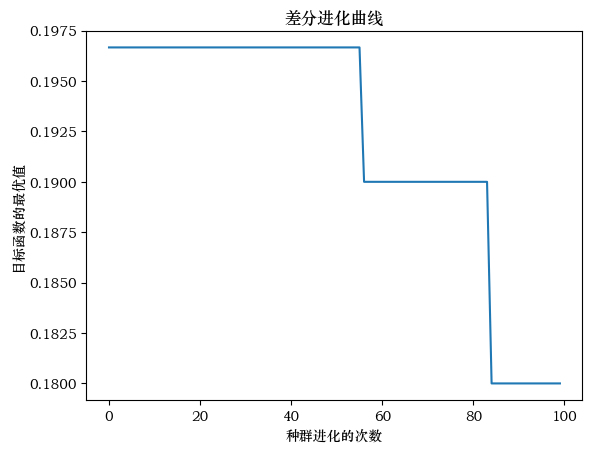

In [8]:
import matplotlib.pyplot as plt

# 设置可显示中文宋体
plt.rcParams['font.family'] = 'STZhongsong'
# 生成 x 轴数据：0 到 G，间隔为 1
x = np.arange(0, number_generations, 1)

# 生成 y 轴数据：每次迭代的最优值
y = per_generation_optimal_value

# 绘制折线图
plt.plot(x, y)

# 设置标题和坐标轴标签
plt.title("差分进化曲线")
plt.xlabel("种群进化的次数")
plt.ylabel("目标函数的最优值")

# 显示图形
plt.show()


## 测试

### 模型测试

In [ ]:
classes, counts = get_classes_indexes_counts(y_train)
num_class,=len(classes)
print("原始数据集分类数：", num_class)
print("原始数据集各分类数量：", counts)

indices = get_indices(x_best)
x_best_sub, y_best_sub, xi = get_sub_dataset(x_best, indices, dataset_x, dataset_y, classes, minimum=10)

num_class_x_best, classes_x_best, counts_x_best = get_classes_indexes_counts(y_best_sub)

print("最优实例子集对应索引：", indices)
print("最优实例子集各分类数量：", counts_x_best)
# 模型训练
x_train, x_test, y_train, y_test = train_test_split(x_best_sub, y_best_sub, test_size=0.3, random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
# 计算错误率
error_rate = 1 - accuracy
print(f'Error_rate: {accuracy:.2f}')
# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

### 虚拟数据测试

In [ ]:
xx = np.array([
    [0.2, 1.2],
    [1.3, 2.4],
    [2.6, 3.5],
    [3.2, 4.2],
    [4.3, 5.4],
    [5.6, 6.5],
    [6.2, 7.2],
    [7.3, 8.4],
    [8.6, 9.5],
    [9.2, 10.2],
    [10.3, 2.4],
    [11.6, 3.5],
    [12.2, 2.2],
    [13.3, 2.4],
    [14.6, 3.5],
    [15.2, 2.2],
    [16.3, 2.4],
    [17.6, 3.5],
    [18.2, 2.2],
    [29.3, 2.4],
    [20.6, 3.5],
    [21.2, 2.2],
    [22.3, 2.4],
    [23.6, 3.5],

])

print(xx.shape)
yy = np.array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])
print(yy.shape)
xi = np.random.rand(24) * (1 - 0) + 0

print("随机生成的个体：", xi)

indexes = get_indices(xi)

print("个体对应的实例索引：", indexes)

classes, counts = get_classes_indexes_counts(yy)
num_class,=len(classes)
print(len(classes))
#print("类：",num_class)

#print("类的数量：",counts)

x_sub, y_sub, xii = get_sub_dataset(xi, indexes, xx, yy, classes, minimum=10)

print("新的xi：", xii)

print("选择的实例子集x：", x_sub)
print("选择的实例子集y：", y_sub)
print("Over")

In [ ]:
import numpy as np

# 创建一个升序的一维数组
arr = np.array([1, 3, 5, 7, 9])

# 要插入的元素
value = 10

# 查找插入位置，保持升序
index = np.searchsorted(arr, value)
print("索引值：", index)
# 在指定位置插入元素
new_arr = np.insert(arr, index, value)

print(new_arr)
